# Solucion tarea 3 - Aprendizaje Supervisado

#### Estudiantes:
- Nicolás Prieto Escobar
- Pablo A. Saldarriaga Aristizabal

### Problema:

Contamos con información hora a hora para los barrios del poblado para los meses de junio a diciembre de 2017. Para cada hora tenemos la información de las condiciones climáticas del barrio, además de tener la etiqueta de si en esa hora ocurrió o no un accidente de tránsito. En base a la información disponible, se quiere predecir si un accidente ocurrirá a cierta hora de forma que agentes de movilidad, abogados de aseguradoras y demás entes puedan estar situados en lugares estratégicos para ir a atender el accidente.

El modelo que usaremos para predecir accidentes en un Random Forest.

In [1]:
%matplotlib notebook

### Importación de paquetes para correr este Notebook

In [2]:
import os
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

In [7]:
import logging
from logging.handlers import RotatingFileHandler

file_name = 'proc_models'
logger = logging.getLogger()
dir_log = f'data/logs/{file_name}.log'

handler = RotatingFileHandler(dir_log, maxBytes=2000000, backupCount=10)
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(process)d - %(name)s - %(levelname)s - %(message)s",
                    handlers = [handler])

### <font color=red>CORRECION</font> 

<font color=red>Realizamos la claridad que el problema de accidentalidad trabajado, es predecir el evento de si va a ocurrir o no un accidente (es decir, el modelo predecirá o la clase 1 o la clase 0, por lo que no se realiza ninguna interpolación de valores), por lo tanto, los analisis realizados en esta tarea están basados en las métricas F-Score, Balanced Accuracy, Precisión, Recall y ROC-AUC. Por la característica del problema, no se utiliza la noción de un error de predicción.</font> 

### Importación y preparación de los datos

In [8]:
data = pd.read_csv('data/data_tarea3.csv', sep = ',')
data['TW'] = pd.to_datetime(data['TW'])

data['poblado'] = data['BARRIO']
data= pd.get_dummies(data, columns=['poblado'])

Se mencionan las variables relevantes encontradas para el problema, estas serán las variables a ser utilizadas en el proceso de predicción de accidentes. El código utilizado para la selección de variables, se encuentra en un script y notebook auxiliares en la carpeta de "archivos auxiliares"

In [9]:
### Variables Relevantes
cols = ['apparentTemperature', 'temperature', 'humidity_mean',
       'temperature_mean', 'apparentTemperature_mean', 'humidity',
       'dewPoint_mean', 'dewPoint', 'windSpeed_mean', 'windSpeed',
       'cloudCover_mean', 'uvIndex', 'icon_partly-cloudy-night',
       'poblado_LaAguacatala', 'visibility_mean', 'cloudCover', 'dia_sem_6',
       'precipIntensity_mean', 'visibility', 'poblado_ElCastillo',
       'icon_partly-cloudy-day', 'poblado_VillaCarlota', 'poblado_Astorga',
       'precipIntensity', 'poblado_AltosdelPoblado', 'precipProbability',
       'hora_7', 'poblado_LosBalsosNo1', 'poblado_ElDiamanteNo2',
       'poblado_Manila', 'poblado_SantaMariadeLosÁngeles', 'poblado_Lalinde',
       'hora_3', 'hora_0', 'hora_1', 'dia_sem_4', 'dia_sem_5', 'hora_2',
       'poblado_ElPoblado', 'poblado_SanLucas', 'poblado_LasLomasNo2',
       'dia_sem_1', 'dia_sem_2', 'poblado_BarrioColombia',
       'poblado_LosBalsosNo2', 'hora_19', 'hora_4', 'dia_sem_3', 'dia_sem_0',
       'hora_17', 'hora_6', 'icon_cloudy']

In [10]:
data['Accidente'].sum()

2069.0

Fase de aumentación del conjunto de datos (binarizar algunas variables, y además agregar para algunos factores climáticos su media en las últimas horas).

In [11]:
### Agregar otras features
data['hora'] = data['TW'].dt.hour
data['dia_sem'] = data['TW'].dt.dayofweek

data= pd.get_dummies(data, columns=['hora'])
data= pd.get_dummies(data, columns=['icon'])
data= pd.get_dummies(data, columns=['dia_sem'])

In [12]:
len(data.columns)

73

In [13]:
### Feature augmentation
freq = '5H'
variables = ['temperature','precipIntensity','apparentTemperature','dewPoint',
             'humidity','windSpeed','cloudCover','visibility']

data_aux = data.copy()
data_aux.index = data_aux.TW
data_aux = data_aux.sort_index()
data_aux = data_aux.drop(columns = 'TW')
resample_data = data_aux[variables].rolling(freq, closed = 'left').mean()

data_pivot = data_aux.pivot_table(values=variables, index='TW',columns='BARRIO', aggfunc=sum)
data_mean = data_pivot.rolling(freq, closed = 'left').mean().stack().reset_index(drop = False)

col_means = [*data_mean.columns[:2]]
for col in data_mean.columns[2:]:
    col_means.append(col + '_mean')
    
data_mean.columns = col_means

data = data.merge(data_mean, how = 'left', on = ['TW','BARRIO'])
data = data.dropna().reset_index(drop = True)

Partimos el conjunto de datos en entrenamiento y prueba. Entrenaremos el modelo utilizando la información disponible entre Junio y Octubre de 2017, y probaremos el modelo para la información de Noviembre y Diciembre de 2017

In [14]:
data_train = data[data['TW']<dt.datetime(2017,11,1)].reset_index(drop = True)
data_test = data[data['TW']>=dt.datetime(2017,11,1)].reset_index(drop = True)

In [15]:
X = data_train.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y = data_train['Accidente'].reset_index(drop=True)               # target feature
X = X[X.columns[2:]]
X = X[cols]

In [16]:
X_test = data_test.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y_test = data_test['Accidente'].reset_index(drop=True)               # target feature
X_test = X_test[X_test.columns[2:]]
X_test = X_test[cols]

In [17]:
X_train = X.copy()
y_train = y.copy()

En vista de estar enfrentando un problema de clasificación en presencia de desbalanceo de clases, realizaremos un undersampling con un porcentaje de 0.4 (porcentaje óptimo encontrado) para luego proceder a entrenar el modelo. El código utilizado para la selección del porcentaje de undersampling, se encuentra en un script y notebook auxiliares en la carpeta de "archivos auxiliares"

In [18]:
tra_0 = int(len(y_train) - y_train.sum())
tra_1 = int(y_train.sum())

prop_deseada_under = 0.4
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

In [19]:
X_train_under.shape

(3787, 52)

### Entrenamiento y selección de modelos

Definimos la función grid, la cual se encargará del entrenamiento de un diccionario de modelos en base a la búsqueda de parámetros, usando la estrategia GridSearch o RandomSearch.

Tanto el método GridSearch como RandomSearch son métodos que se encargan de explorar el espacio de combinación de hiperparametros para la obtención del mejor modelo en un problema de aprendizaje supervisado, siendo GridSearch un método más exahustivo, ya que considera todas las combinaciones posibles, mientras que RandomSearch considera una muestra aleatoria, por lo que esta segunda es más rápida.

Para la elección del mejor modelo, consideramos la métrica del área bajo la curva ROC, por lo que internamente, estos métodos utilizan la estrategia de validación cruzada, y se obtiene el modelo cuyo ROC en el proceso de validación sea mejor. Esta técnica usa undersampling para todos los datos entre junio y octubre para obtener los mejores hiperparámetros para nuestro modelo de random forest.

In [20]:
def grid(base_path, now_date, path_file, X, Y, models, score = 'roc_auc', cv = 2, n_proc = 2, random = False, n_iter = 10):    
    
    for name in models:

        t_ini = time.time()

        pipeline = Pipeline([('scaler', StandardScaler()), (name,  models[name]['mod'])])
        parameters = {}          
        for par in models[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = models[name]['par'][par]
        
        if random:
            mod_aux = RandomizedSearchCV(pipeline, parameters, n_jobs = n_proc,\
                              scoring = score, verbose=1, cv = cv, n_iter = n_iter)
        else:
            mod_aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc,\
                              scoring = score, verbose=1, cv = cv)
                
        mod_aux.fit(X, Y)
        models[name]['bestModel'] = mod_aux.best_estimator_
        models[name]['roc'] = mod_aux.best_score_

        selection_time = time.time() - t_ini

        models[name]['selection_time'] = selection_time

        sample_f_path = os.path.join(base_path, path_file, f'{name}_{now_date.strftime("%Y%m%d_%H%M")}.sav')

        joblib.dump(models[name]['bestModel'], sample_f_path)

        print(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        print(f"El ROC de la familia {name} es: {models[name]['roc']:0.3f}")
        print('*'*80)
        
        logger.info(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        logger.info(f"El ROC de la familia {name} es: {models[name]['roc']:0.3f}")
        logger.info('*'*80)        
       
    mod_name = None
    best_roc = 0
    for name in models:
        if models[name]['roc'] > best_roc:
            mod_name = name
            best_roc = models[name]['roc']

    print(f"El mejor modelo fue: {mod_name} con un ROC de: {best_roc}")
    
    logger.info(f"El mejor modelo fue: {mod_name} con un ROC de: {best_roc}")
    
    return models, mod_name

### Resultados

Definimos un diccionario de modelos, en el cual estarán los valores de los hiperparámetros del modelo que se desean ajustar. Para el caso del modelo de Random Forest que utilizaremos en nuestro caso, solo vamos a buscar optimizar los dos hiperparámetros más importantes del modelo, que son la cantidad de árboles a considerar en el bosque y la máxima profundidad en niveles de cada árbol.

In [21]:
modelo_final = {
                     'rforest_final':{
                                'mod': RandomForestClassifier(random_state= 42, bootstrap = True, criterion = 'entropy'),
                                'par': {'n_estimators':[10,20,30,40,50,60,70,80,90,100,200,300,400,500],
                                        'max_depth': [None, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70]
                                       }
                     }
                 }

Se usa la función Grid para entrenar y guardar el mejor modelo. Consideramos para el método de grid, un parámetro de 4 validaciones cruzadas para cada una de las combinaciones de hiperparámetros

In [ ]:
base_path = os.getcwd()
now_date = dt.datetime.now()
path_file = 'data/models'
models, mod_name = grid(base_path, 
                        now_date, 
                        path_file,  
                        X_train_under, 
                        y_train_under, 
                        modelo_final, 
                        score = 'roc_auc', 
                        cv =4 , 
                        n_proc = 11,
                        random = False,
                        n_iter = 20)

Una vez ejecutada la celda, obtenemos el siguiente output:

El tiempo de seleccion fue: 88.439 s

El ROC de la familia rforest_final es: 0.741

 El modelo obtenido es:
 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False)
                        
Notar entonces que se obtuvo para n_estimators un valor de 500 (el bosque considera 500 arboles) y su maxima profundidad es de 10

### Desempeño del modelo en el conjunto de prueba

Realizamos carga del modelo entrenado para realizar la predicción de los accidentes en el conjunto de prueba

In [22]:
model = joblib.load('data/models/rforest_final_20200228_1144.sav')

In [23]:
model.steps[0]

('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))

Realizamos las predicciones de los accidentes en el conjunto de prueba. Por las características del problema que se está tratando (gran desbalance de clases), decidimos no utlizar la métrica de accuracy, y por el contrario, utilizamos las siguientes métricas:

- Área de la curva ROC
- Recall
- Precision
- FScore
- Balanced Accuracy

In [24]:
predicciones = model.predict(X_test)
probabilidades = model.predict_proba(X_test)[:,1]

In [25]:
fscore = f1_score(y_test, predicciones)
roc = roc_auc_score(y_test, probabilidades)
sensibilidad = recall_score(y_test, predicciones)
precision =precision_score(y_test, predicciones)
b_accuracy = balanced_accuracy_score(y_test, predicciones)

print(f'El roc es {roc}')
print(f'La sensibilidad es {sensibilidad}')
print(f'La precision es {precision}')
print(f'El fscore es {fscore}')
print(f'El balanced accuracy es {b_accuracy}')

El roc es 0.7594576244850463
La sensibilidad es 0.5750452079566004
La precision es 0.04757630161579892
El fscore es 0.08788171894431393
El balanced accuracy es 0.6869697687232061


Vemos que de las medidas encontradas, tenemos buenos desempeños tal como ocurre con el ROC_AUC, que es un valor muy cercano al valor obtenido en el conjunto de validación cuando se seleccionó el modelo (ROC_AUC de 0.742), igualmente vemos un valor alto en la sensibilidad (recall) y un valor bueno para el balanced accuracy. Se puede concluir entonces que abordar el problema de predicción de accidentes puede traer resultados prometedores.

<IPython.core.display.Javascript object>


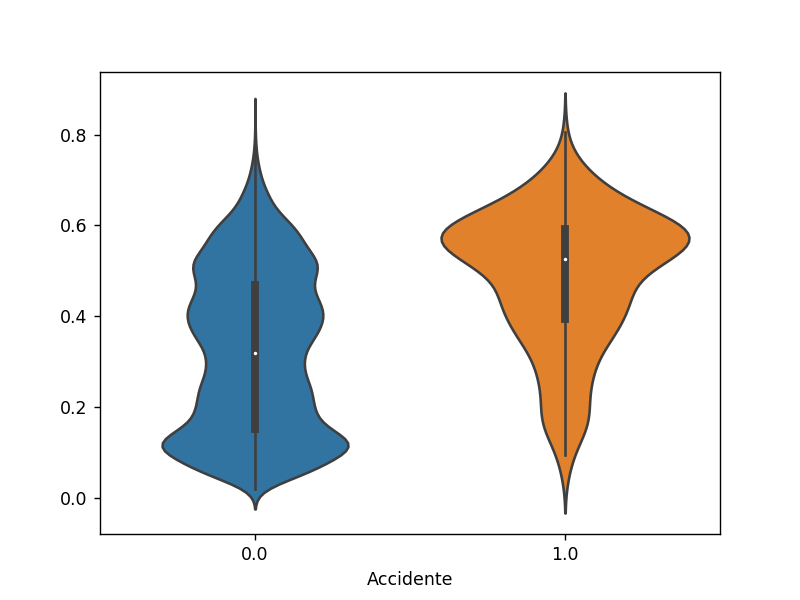

In [26]:
ax = sns.violinplot(x=y_test , y = probabilidades)

Del diagrama de violín anterior, podemos ver la distribución de la probabilidad que entrega el modelo para los datos del conjunto de prueba diferenciando la occurencia de accidente con la no ocurrencia, viendo que para el caso de los accidentes (violín naranja), hay una mayor concentración por encima de una probabilidad de 0.5, al igual que la mitad de los datos (pues vemos que la mediana se encuentra por encima de 0.5), por lo que es un comportamiento que se esperaría del modelo. Analogamente, vemos que tiene sentido una distribución alta en el caso de no accidentes (violín azul), donde la mayor masa de probabilidad se encuentra en valores bajos

<IPython.core.display.Javascript object>


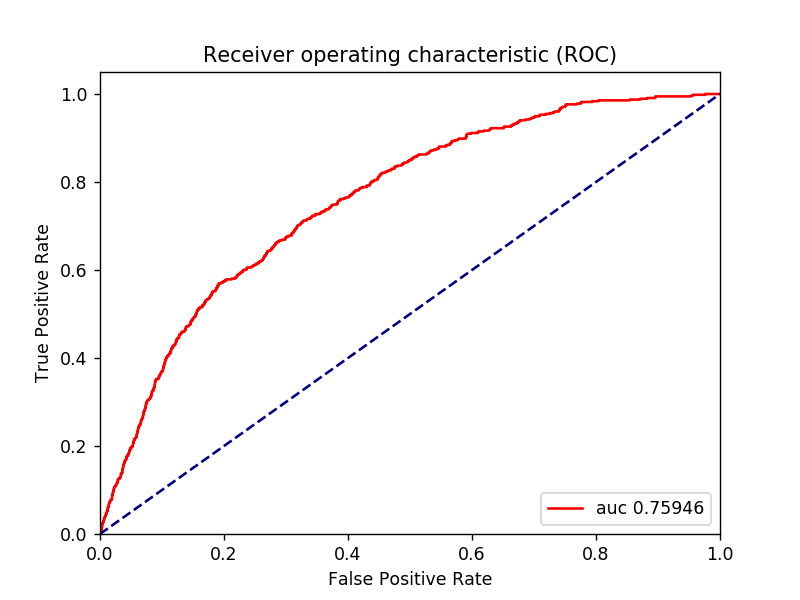

Text(0.5, 1.0, 'Receiver operating characteristic (ROC)')

In [27]:
### Grafica de la curva ROC en el conjunto de prueba
fig, ax = plt.subplots()  

fpr, tpr, _ = roc_curve(y_test, probabilidades, drop_intermediate=False)
roc_auc = roc_auc_score(y_test, probabilidades)

ax.plot(fpr, tpr, color='red', label=f'auc %0.5f' % roc_auc)    
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.legend(loc="lower right")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')    
ax.set_title('Receiver operating characteristic (ROC)')

Vemos que la gráfica de la curva ROC en el conjunto de prueba apoya la noción que se tiene de que los resultados del modelo son prometedores (un ROC_AUC cercano a 0.75 indica resultados decentes).

## Analisis de Sensibilidad 

Modelo: Random Forest

En esta parte del notebook, analizaremos el comportamiento del desempeño del modelo a medida que variamos sus dos principales hiperparametros: la cantidad de árboles a considerar en el bosque, y la profundidad máxima de cada árbol. Para esto, partimos el conjunto de datos en entrenamiento y validación (usando la proporción de undersampling de 0.4).

In [28]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

tra_0 = int(len(y_train1) - y_train1.sum())
tra_1 = int(y_train1.sum())

prop_deseada_under = 0.4
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train_under1, y_train_under1 = rus.fit_sample(X_train1, y_train1)

Para cada una de estas validaciones, variaremos solo el valor del hiperparámetro que estamos analizando (sea n_estimators o max_depth). El resto de hiperparámetros se fijan en los valores hallados en el mejor modelo del grid search (max_depth fue de 10 y n_estimators fue de 500).

# n_estimators

Veamos primero que pasa al variar el hiperparámetro de n_estimators (número de árboles en el bosque). 

In [35]:
times = []
rocs = []
n_estimators = [10,20,30,40,50,60,70,80,90,100, 110, 120, 140, 150, 160, 170, 180, 190,200, 210, 
                220, 240, 250, 260, 270, 280, 290,  300,310, 320, 330, 340, 350, 360, 370, 380, 
                390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 
                560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]
for n in n_estimators:
    
    clf = RandomForestClassifier(n_estimators = n, random_state= 42, bootstrap = True, max_depth = 10)

    scaler = StandardScaler()
    X_train_under1 = scaler.fit_transform(X_train_under1)
    
    start = time.time()
    clf.fit(X_train_under1, y_train_under1)
    times.append(time.time() - start)
    
    X_val = scaler.transform(X_val)
    preds = clf.predict_proba(X_val)[:,1]
    
    rocs.append(roc_auc_score(y_val, preds))

<IPython.core.display.Javascript object>


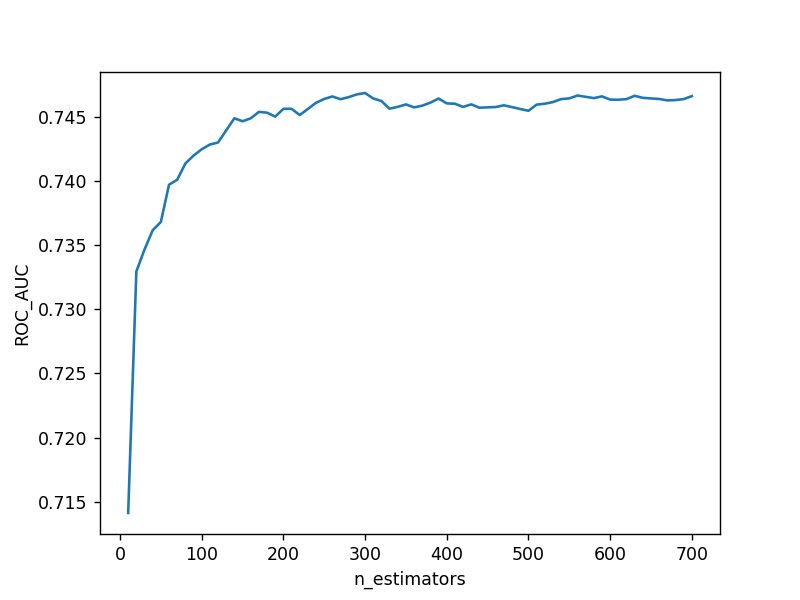

Text(0, 0.5, 'ROC_AUC')

In [36]:
ax = plt.figure('roc vs Tiempo Computo - n_estimators')
plt.plot(n_estimators,rocs)
plt.xlabel('n_estimators')
plt.ylabel('ROC_AUC')

<IPython.core.display.Javascript object>


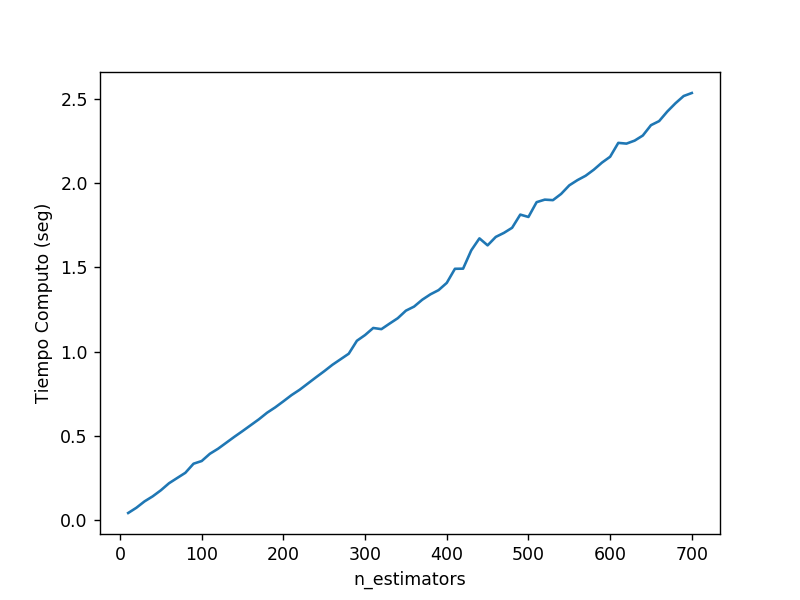

Text(0, 0.5, 'Tiempo Computo (seg)')

In [37]:
ax = plt.figure('n_estimators vs Tiempo Computo')
plt.plot(n_estimators,times)
plt.xlabel('n_estimators')
plt.ylabel('Tiempo Computo (seg)')

Como se esperaba, al ser ranfom forest un método de bagging, aumentar los arboles va a ayudar a que se reduzca la varianza total del método y asi se mejoren sus predicciones. Sin embargo, llegará un momento donde la varianza converja a un mínimo y no se logren mayores mejoras, por lo que seguir aumentando la cantidad de arboles sólo aumentará el tiempo de cómputo pero no aumentará de forma significativa el rendimiento del modelo. Por esta razón, consideramos que usar 500 árboles en el bosque ya es suficiente (se logran ya buenos resultados; poner un valor más alto hará que se aumente mucho el tiempo de cómputo).

## Max_depth

Ahora, veamos que pasa al variar el hiperparámetro de max_depth (profundidad máxima de cada árbol). 

In [32]:
times2 = []
rocs2 = []
max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for max_d in max_depth:
    
    clf = RandomForestClassifier(max_depth = max_d, random_state= 42, bootstrap = True, n_estimators = 500)
    
    scaler = StandardScaler()
    X_train_under1 = scaler.fit_transform(X_train_under1)
    
    start = time.time()
    clf.fit(X_train_under1, y_train_under1)
    times2.append(time.time() - start)
    
    X_val = scaler.transform(X_val)
    preds = clf.predict_proba(X_val)[:,1]
    
    rocs2.append(roc_auc_score(y_val, preds))

<IPython.core.display.Javascript object>


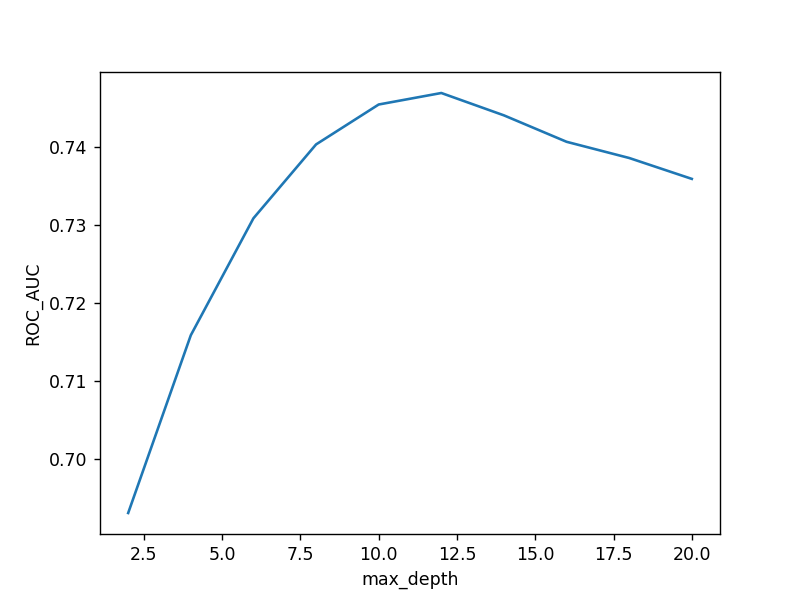

Text(0, 0.5, 'ROC_AUC')

In [33]:
ax = plt.figure('roc vs Tiempo Computo - max_depth')
plt.plot(max_depth,rocs2)
plt.xlabel('max_depth')
plt.ylabel('ROC_AUC')

<IPython.core.display.Javascript object>


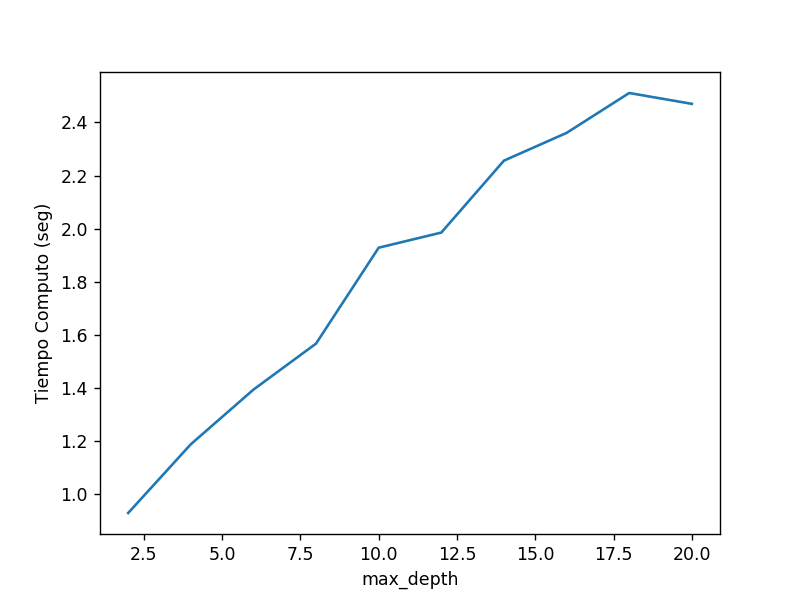

Text(0, 0.5, 'Tiempo Computo (seg)')

In [34]:
ax = plt.figure('max_depth vs Tiempo Computo')
plt.plot(max_depth,times2)
plt.xlabel('max_depth')
plt.ylabel('Tiempo Computo (seg)')

Cómo es de esperarse, vemos que, al aumentar la profundidad máxima de cada uno de los árboles, el tiempo de cómputo aumenta, pues de ajustan más ramas y se deben de hacer más divisiones en el árbol en el proceso de entrenamiento, pero a la vez, es interesante ver que un número grande de profundidad máxima no es óptimo, ya que vemos que el valor de la curva ROC va disminuyendo después de alcanzar su valor máximo en 10 aproximadamente (tal como se determinó en nuestra grid search). Esto se puede deber a que, teniendo árboles muy profundos, el modelo se esté sobre ajustando demasiado. Es necesario entonces elegir un valor de max_depth de tal forma que cada árbol tenga un error bajo, pero que no lleve a que cada árbol se sobreajuste demasiado y el modelo tenga una varianza alta.

#### Conclusión

Luego de analizados todos estos factores, podemos concluir que fue posible obtener un modelo de Random Forest que tenga un desempeño decente y prometador a la hora de predecir accidentes en la comuna del Poblado. Además, mostramos la importancia que tiene llevar a cabo de manera juiciosa varias de las partes del ciclo de un modelo de machien learning supervisado (feature selection, determinar valor de undersampling, ajustar hiperparámetros y analizar su sensibilidad).